In [1896]:
import os
import warnings

import pandas as pd
import numpy as np


from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
)
from jre_utils.config import asset_types
from jp_prefecture.jp_cities import JpCity, jp_cities
from geopy.geocoders import Nominatim

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [1897]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)


def map_time_units(x):
    mapping = {
        "30-60minutes": 45,
        "1H-1H30": 75,
        "1H30-2H": 105,
        "2H-": 135,
    }
    
    return int(x) if x.isdigit() else mapping[x]

def map_layout(x):
    if x == "na":
        return "na"

    x = x.split("+")[0]

    if x[0].isdigit() and int(x[0]) == 1:
        if x != "1K" and x != "1LDK" and x != "1DK":
            return "1other"
        return x
    
    if x[0].isdigit() and int(x[0]) == 2:
        if x != "2LDK" and x != "2DK":
            return "2other"
        return x

    if x[0].isdigit() and int(x[0]) > 2:
        return f"{min(int(x[0]), 5)}LDK"
    
    return "other"

def map_land_shape(x):
    x = x.lower()
    x = x.replace("semi-", "")
    return x

def map_frontage(x):
    if x == "na":
        return 0
    if x == "50.0m or longer.":
        return 55
    return int(x.split(".")[0])

def map_floor_area(x):
    if "less" in x:
        return 10
    elif "greater" in x:
        return 2000
    else:
        return int(x)
    
def map_year_of_construction(x):
    if x == "before the war":
        return 1930
    
    return int(x)

In [1898]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}") 

def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

def get_city_geocode(area_code):
    area_code = str(area_code)
    try:
        return tuple(jp_cities.citycode2geodetic(area_code)) 
    except:
        print(f"Could not find geocode for {area_code}")
        return np.NaN, np.NaN
    
def find_town_jp(all_towns_df, city_code, town_name, log=False):
    city_df = all_towns_df[all_towns_df["cityCode"] == int(city_code)]
    town_df = city_df[city_df["townAlphabet"].str.contains(town_name)]
    
    if town_df.empty:
        if log:
            print(f"JP could not find {town_name} in {city_code}")
        return None, None
    
    return town_df["longitude"].mean(), town_df["latitude"].mean()

def find_town_geopy(geolocator, address, log=False):
    location_info = geolocator.geocode(address)

    if not location_info:
        if log:
            print(f"Geopy could not find {address}")
        return None, None
    
    return location_info.longitude, location_info.latitude

def get_town_coordinates_jp(all_towns_df, city_name, city_code, town_name, log=False):
    geolocator = Nominatim(user_agent="my_app")
    
    # Try to locade in df - this is fast
    jp_lon, jp_lat = find_town_jp(all_towns_df, city_code, town_name, log)

    if not jp_lon or not jp_lat:
        address = f"{town_name}, {city_name}, Japan"
        
        # Fall back and try to locate with geopy - this is slow
        geopy_lon, geopy_lat = find_town_geopy(geolocator, address, log)
        
        if not geopy_lon or not geopy_lat:
            # if nothing works, just return the city coordinates
            return get_city_geocode(city_code)
        
        return geopy_lon, geopy_lat

    return jp_lon, jp_lat



'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [2939]:
prefecture_code = 39
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/39_Kochi Prefecture_20053_20233.csv'

In [2940]:
df = pd.read_csv(
    trade_prices_data_paths[prefecture_code - 1],
    encoding="unicode_escape",
    index_col="No",
)
df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

# we may want to skip the following step in the future
df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
df["area"] = df["area_code"].apply(get_area_from_area_code)

df["trade_price"] = df["Transaction-price(total)"]
df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
df["unit_price"] = df["Transaction-price(Unit price m^2)"]
df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

df["unit_price"] = np.where(
    df["unit_price"].isna(),
    df["trade_price_per_area"],
    df["unit_price"],
)

df = df[
    df["Type"].isin(
        [
            asset_types["building"]["label"],
            asset_types["land"]["label"],
            asset_types["condo"]["label"],
        ],
    )
]

# Renaming

df = df.rename(columns = {
    "Type": "asset_type",
    "Region": "neighbourhood_classification",
    "Area": "subarea",
    "Nearest stationFName": "nearest_station",
    "Nearest stationFDistance(minute)": "time_to_nearest_station",
    "Layout": "layout",
    "Land shape": "land_shape",
    "Frontage": "frontage",
    "Total floor area(m^2)": "total_floor_area",
    "Year of construction": "year_of_construction",
    "Building structure": "building_structure",
    "Use": "use",
    "Purpose of Use": "purpose",
    "Frontage roadFDirection": "frontage_road_direction",
    "Frontage roadFClassification": "frontage_road_classification",
    "Frontage roadFBreadth(m)": "frontage_road_breadth",
    "City Planning": "zone",
    "Maximus Building Coverage Ratio(%)": "max_building_coverage_ratio",
    "Maximus Floor-area Ratio(%)": "max_floor_area_ratio",
    "Renovation": "renovation_status",
    "Transactional factors": "transactional_factors", # need to format and include
})

# Process factors

df["subarea"] = df["subarea"].fillna("")
df["neighbourhood_classification"] = df["neighbourhood_classification"].fillna("na")
df["nearest_station"] = df["nearest_station"].fillna("na")
df["time_to_nearest_station"] = df["time_to_nearest_station"].fillna("30-60minutes").apply(map_time_units)
df["layout"] = df["layout"].fillna("na").apply(map_layout)
df["land_shape"] = df["land_shape"].fillna("na").map(map_land_shape)
df["frontage"] = df["frontage"].fillna("na").apply(map_frontage)

df["total_floor_area"] = np.where(
    df["total_floor_area"].isna(),
    df["trade_area"].astype(str),
    df["total_floor_area"],
)

df["total_floor_area"] = df["total_floor_area"].apply(map_floor_area)


df["year_of_construction"] = np.where(
    df["year_of_construction"].isna(),
    (df["year"] - 30).astype(str),
    df["year_of_construction"],
)

df["year_of_construction"] = df["year_of_construction"].apply(map_year_of_construction)
df["age"] = (df["year"] - df["year_of_construction"]).apply(lambda x: max(x, 0))

df["building_structure"] = df["building_structure"].fillna("na")
df["frontage_road_direction"] = df["frontage_road_direction"].fillna("na")
df["frontage_road_classification"] = df["frontage_road_classification"].fillna("na")
df["frontage_road_breadth"] = df["frontage_road_breadth"].fillna("0.0").astype(float)
df["zone"] = df["zone"].fillna("na")
df["max_building_coverage_ratio"] = df["max_building_coverage_ratio"].fillna(0)
df["max_floor_area_ratio"] = df["max_floor_area_ratio"].fillna(0)
df["renovation_status"] = df["renovation_status"].fillna("na")


df["use"] = df["use"].fillna("na")
df["purpose"] = df["purpose"].fillna("na")
df["transactional_factors"] = df["transactional_factors"].fillna("na")

df = df.drop(columns = [
    "City,Town,Ward,Village code",
    "City,Town,Ward,Village",
    "Transaction-price(total)",
    "Area(m^2)",
    "Transaction-price(Unit price m^2)",
    "trade_price_per_area",
    "Transaction period",
    "Prefecture",
])

In [2941]:
# Convert towns into Longitude and Latitude
# jp_towns = JpCity(enable_town=True)
# towns_df = jp_towns.towns
# towns_df["townAlphabet"] = towns_df["townAlphabet"].fillna("")

# towns_list_df = df[["area", "area_code", "subarea"]].drop_duplicates()
# towns_list_df[["long", "lat"]] = towns_list_df.apply(
#     lambda x: pd.Series(get_town_coordinates_jp(towns_df, x["area"], x["area_code"], x["subarea"])),
#     axis=1,
# )

subarea_coords_simple_path = f"{DATA_DIRECTORY_PATH}/coordinates/subarea_simple.csv"
subarea_coords_simple_path = f"{DATA_DIRECTORY_PATH}/coordinates/subarea.csv"
coordinates_df = pd.read_csv(subarea_coords_simple_path)
coordinates_df["area_code"] = coordinates_df["area_code"].astype(str)

In [2942]:
# Advanced preprocessing
df = df.merge(coordinates_df, on=["area", "area_code", "subarea"], how="left")


In [2943]:
land_df = df[df["asset_type"] == asset_types["land"]["label"]]
building_df = df[df["asset_type"] == asset_types["building"]["label"]]
condo_df = df[df["asset_type"] == asset_types["condo"]["label"]]

dfs_dict = {
    "land": land_df,
    "building": building_df,
    "condo": condo_df
}

In [2944]:
id_columns = ["year"]
metric_columns = ["unit_price_log"]

# land_df.info()

land_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "transactional_factors",
    ],
}

# building_df.info()

building_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "total_floor_area",
        "trade_area",
        "age",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

# condo_df.info()

condo_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "age",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "renovation_status",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

columns_dicts = {
    "land": land_columns,
    "building": building_columns,
    "condo": condo_columns
}

In [2945]:
def filter_df(df):
    return df[
        (df["neighbourhood_classification"] != "Industrial Area")
        & (
            ~df["use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
        & (
            ~df["purpose"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
    ]

In [2991]:
# area_code = "30201" # pretty bad
# area_code = "13105"
area_code = "39386"
asset_type = "land"
asset_df = dfs_dict[asset_type]
columns_dict = columns_dicts[asset_type]

numerical_columns = columns_dict["numerical_columns"]
categorical_columns = columns_dict["categorical_columns"]
comma_separated_categorical_columns = columns_dict["comma_separated_categorical_columns"]
all_unprocessed_columns = numerical_columns + categorical_columns + comma_separated_categorical_columns

In [2992]:
# filtered_asset_df = filter_df(asset_df)
filtered_asset_df = asset_df
area_df = filtered_asset_df[filtered_asset_df["area_code"] == area_code].reset_index(drop=True)

area_df["year"] = area_df["year"].astype(str)
area_df["quarter"] = area_df["quarter"].astype(str)
area_df[f"unit_price_log"] = np.log(area_df["unit_price"])
# area_df[f"unit_price_log"] = area_df["unit_price"]


for column in numerical_columns:
    area_df[column] = area_df[column].fillna(area_df[column].mean())
    area_df[column] = np.log(area_df[column] + 1)

# Scale numerical variables
scaler = StandardScaler()
area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])
# area_df[["unit_price_log"]] = scaler.fit_transform(area_df[["unit_price_log"]])

# Categorical variables
area_df = pd.get_dummies(
    area_df[all_unprocessed_columns + id_columns + metric_columns],
    columns=categorical_columns,
)

# Comma Separated Categorical variables
for column in comma_separated_categorical_columns:
    one_hot_df = (
        area_df[column]
        .str.replace(" ", "")
        .str.get_dummies(sep=",")
        .rename(columns=lambda x: column + x)
    )
    area_df = pd.concat([area_df, one_hot_df], axis=1)
    area_df = area_df.drop(columns=[column])

drop_columns = [col for col in area_df.columns if "na" in col]
area_df = area_df.drop(columns=drop_columns)
area_df

,long,lat,time_to_nearest_station,trade_area,frontage,frontage_road_breadth,max_building_coverage_ratio,max_floor_area_ratio,year,unit_price_log,neighbourhood_classification_Commercial Area,neighbourhood_classification_Industrial Area,neighbourhood_classification_Potential Residential Area,neighbourhood_classification_Residential Area,quarter_1,quarter_2,quarter_3,quarter_4,zone_Category I Exclusively Low-story Residential Zone,zone_Category I Residential Zone,zone_Category II Residential Zone,zone_Industrial Zone,zone_Neighborhood Commercial Zone,zone_Outside City Planning Area,zone_Quasi-industrial Zone,zone_Quasi-residential Zone,zone_Urbanization Control Area,purpose_Factory,purpose_House,purpose_Office,purpose_Other,purpose_Warehouse,land_shape_&quot;flag-shaped&quot; etc.,land_shape_irregular shaped,land_shape_rectangular shaped,land_shape_shaped,land_shape_square shaped,land_shape_trapezoidal shaped,frontage_road_direction_East,frontage_road_direction_No facing road,frontage_road_direction_North,frontage_road_direction_Northeast,frontage_road_direction_Northwest,frontage_road_direction_South,frontage_road_direction_Southeast,frontage_road_direction_Southwest,frontage_road_direction_West,frontage_road_classification_Access Road,frontage_road_classification_Agricultural Road,frontage_road_classification_City Road,frontage_road_classification_Prefectural Road,frontage_road_classification_Private Road,frontage_road_classification_Road,frontage_road_classification_Town Road,frontage_road_classification_Ward Road
0,0.535903,-0.562829,-0.344032,-0.423624,-0.287780,-0.237385,0.307866,0.436708,2022,9.903488,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0.535966,-0.562747,-1.060547,-0.226573,0.157966,-0.237385,0.307866,0.436708,2018,11.002100,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.536046,-0.562871,-0.581246,0.585833,0.747549,-0.421441,0.307866,0.436708,2022,10.714418,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.536046,-0.562871,-0.878325,-0.558193,0.063971,-0.272678,0.307866,0.436708,2018,10.275051,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.536348,-0.562384,-0.241176,-0.121376,0.463839,0.583670,0.307866,-0.009371,2023,11.127263,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.209368,0.334455,-0.581246,1.656612,-2.206825,0.668902,0.307866,0.436708,2007,11.097410,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
266,0.209368,0.334455,-0.456699,0.463634,-2.206825,-0.237385,0.307866,0.436708,2007,11.918391,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
267,0.209368,0.334455,-0.146557,-0.558193,0.322713,-3.048934,0.307866,0.436708,2007,11.141862,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
268,0.209368,0.334455,-0.146557,-0.423624,0.463839,-0.963255,0.307866,-0.009371,2007,10.691945,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [2993]:
# Q1 = area_df['unit_price_log'].quantile(0.25)
# Q3 = area_df['unit_price_log'].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds for what is considered an outlier
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out the outliers
# area_df = area_df[(area_df['unit_price_log'] >= lower_bound) & (area_df['unit_price_log'] <= upper_bound)].reset_index(drop=True)
# area_df

In [2994]:
X_ord = area_df.drop(columns=id_columns + metric_columns)

In [2995]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_ord)

# Print the number of components retained by PCA
print("Number of components retained by PCA:", pca.n_components_)
print(X_pca.shape)

Number of components retained by PCA: 24
(270, 24)


In [2996]:
yearly_df = area_df[id_columns + metric_columns]
yearly_df = pd.get_dummies(yearly_df, columns=id_columns, drop_first=True)
yearly_df = pd.concat(
    [
        yearly_df,
        pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]),
    ],
    axis=1,
)
yearly_df

,unit_price_log,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,9.903488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.311322,-0.740303,-0.641449,-0.649591,-0.005415,0.130282,-0.787893,0.207544,-0.998907,-0.592540,0.398968,0.264395,0.060841,0.493085,-0.259929,0.376127,-0.428586,0.346037,0.163149,-0.113522,-0.039398,0.070732,0.114122,-0.168877
1,11.002100,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.624966,-0.939642,-0.346109,-0.333732,-0.310448,0.877707,-0.819934,-0.237923,-0.107535,-0.516651,0.615504,0.625047,-0.145337,0.991013,0.013498,0.219274,-0.352860,0.052165,0.200329,-0.079579,-0.040201,0.199382,-0.127197,-0.176002
2,10.714418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.360167,-1.074304,0.179184,0.251458,-0.731426,0.349553,-0.626281,-0.624499,-0.731753,0.610671,0.703690,0.891833,0.141383,-0.365741,0.192404,0.476630,-0.189594,-0.075394,0.182806,-0.219075,-0.052147,0.273060,0.092689,-0.146891
3,10.275051,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.431305,-0.945451,-0.545043,-0.381322,-0.318623,0.648963,0.726060,-0.375807,-0.087947,-0.616052,-0.200839,0.182790,-0.414209,-0.875701,0.791213,0.012910,0.004030,-0.392918,0.138526,-0.061863,-0.385341,-0.121348,0.091326,-0.287220
4,11.127263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.115900,-0.881291,0.567339,-0.453340,-0.106721,0.299569,-0.155851,-0.471864,0.592513,-0.600573,-0.008044,-0.689918,-0.214501,0.790296,0.220883,0.122619,-0.034418,-0.194489,-0.048207,0.223170,-0.403424,0.005755,-0.084774,0.119090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,11.097410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.685929,-0.244381,-0.400120,1.597957,2.251076,-0.043517,0.040034,-0.583821,0.293363,-0.609988,1.482051,-0.090364,0.257601,0.347770,-0.091986,-0.060934,0.012175,-0.075911,0.132835,0.146940,0.197208,-0.343950,-0.164658,-0.125212
266,11.918391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.743627,-0.035731,-1.407398,0.665933,1.512780,0.050916,0.235628,-1.186197,-0.844655,-0.346894,-0.044892,-0.031803,0.713908,0.511790,0.437290,0.072569,-0.157976,0.251388,0.278035,0.163051,0.025794,-0.079747,-0.069410,0.198141
267,11.141862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.516973,0.128498,-2.083902,0.507795,-2.225230,-0.230873,0.611864,-0.306868,-0.415146,0.522729,-0.140262,0.435878,1.093253,0.227186,0.472956,-0.142961,-0.226992,-0.104049,0.631175,0.171647,0.139212,-0.043430,0.226234,-0.091355
268,10.691945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.227081,-0.076103,-0.505019,-0.187556,-1.134895,-0.147704,0.347156,-0.988755,0.112164,0.292564,-0.307395,-0.674895,0.359469,-0.227129,0.342677,0.152206,-0.050856,0.127971,0.209204,0.243426,0.247322,-0.174732,-0.331244,-0.035210


<Axes: ylabel='Frequency'>

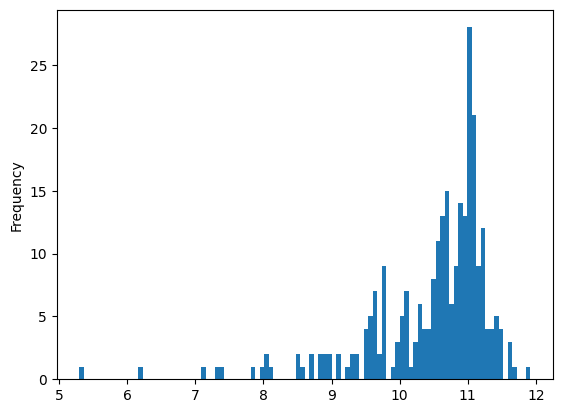

In [2997]:
yearly_df["unit_price_log"].plot.hist(bins=100)

In [2998]:
def get_price_index_from_regression(regression_results, prefix=""):

    yearly_results = regression_results.params.filter(like="year_")
    yearly_results = yearly_results.apply(lambda x: np.exp(x)) # maybe not minus 1
    base_year = min(yearly_results.index)
    base_coef = yearly_results[base_year]
    yearly_results = yearly_results / base_coef * 100

    yearly_results.name = f"{prefix}price_index"


    yearly_p_value = regression_results.pvalues.filter(like="year_")
    yearly_p_value.name = f"{prefix}p_value"

    results_df = pd.concat([yearly_results, yearly_p_value], axis=1).round(4)
    results_df = results_df.reset_index().rename(columns={"index": "year"})
    results_df["year"] = results_df["year"].apply(lambda x: x.split("_")[1])
    return results_df

In [2999]:
X = yearly_df.drop(columns=metric_columns)
y = yearly_df[metric_columns[0]]

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the OLS model
ordinary_results = sm.OLS(y, X).fit()
print(ordinary_results.summary())
ordinary_results_df = get_price_index_from_regression(ordinary_results)
ordinary_results_df

                            OLS Regression Results                            
Dep. Variable:         unit_price_log   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     11.25
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           2.05e-35
Time:                        11:15:13   Log-Likelihood:                -214.47
No. Observations:                 270   AIC:                             510.9
Df Residuals:                     229   BIC:                             658.5
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8205      0.128     84.597      0.0

,year,price_index,p_value
0,2008,100.0000,0.3045
1,2009,109.9012,0.5056
2,2010,78.9366,0.0149
3,2011,96.2521,0.1422
4,2012,111.5403,0.5570
5,2013,101.1250,0.2400
6,2014,87.6598,0.1067
7,2015,61.9794,0.0064
8,2016,69.6952,0.0039
9,2017,89.9263,0.1089


In [3000]:
# Create an RLM model object
robust_model = sm.RLM(y, X)

# Fit the model
robust_results = robust_model.fit()

# Print out the summary of the regression results
print(robust_results.summary())
robust_results_df = get_price_index_from_regression(robust_results)
robust_results_df

                    Robust linear Model Regression Results                    
Dep. Variable:         unit_price_log   No. Observations:                  270
Model:                            RLM   Df Residuals:                      229
Method:                          IRLS   Df Model:                           40
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 30 Mar 2024                                         
Time:                        11:15:13                                         
No. Iterations:                    28                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8654      0.107    101.941      0.0

,year,price_index,p_value
0,2008,100.0000,0.2500
1,2009,105.8738,0.3494
2,2010,79.3302,0.0049
3,2011,94.3967,0.0726
4,2012,105.4239,0.3381
5,2013,107.3223,0.3591
6,2014,86.3669,0.0523
7,2015,63.9467,0.0021
8,2016,72.0075,0.0013
9,2017,83.1278,0.0214


<Axes: xlabel='year'>

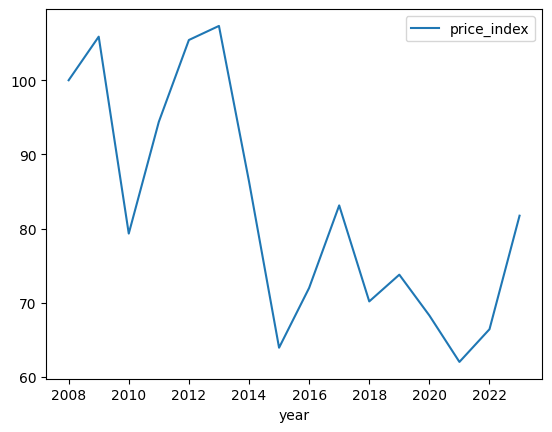

In [3001]:
robust_results_df.plot.line(y="price_index", x="year")

<Axes: xlabel='year'>

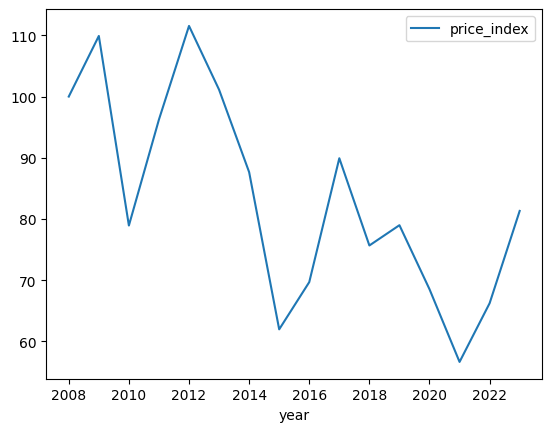

In [3002]:
ordinary_results_df.plot.line(y="price_index", x="year")

<Axes: xlabel='year'>

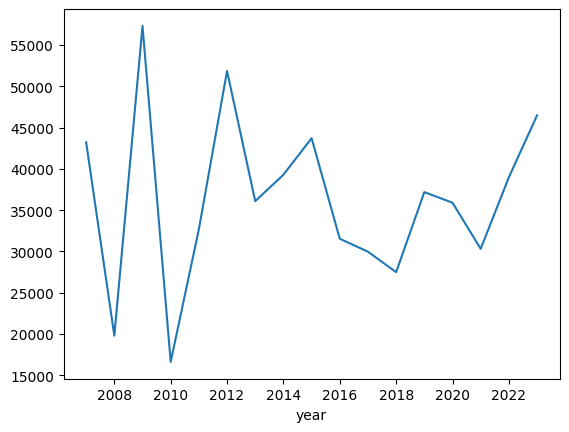

In [3003]:
area_df_2 = asset_df[asset_df["area_code"] == area_code].reset_index(drop=True)
area_df_2.groupby(['year'])['unit_price'].apply(lambda x: np.exp(np.log(x).mean())).plot.line()